In [1]:
import numpy as np
import lysis
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.patches import Patch

from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

In [2]:
e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code="2023-01-31-1300")
e.read_file()
rng = np.random.default_rng(65463453)
file_code = ".f-normal.dat"

In [3]:
print(e)

experiment_code : 2023-01-31-1300
data_filenames  : unbinding_time    : tsectPA.dat
                  lysis_time        : lysismat.dat
                  total_lyses       : lenlysisvect.dat
                  degradation_state : deg.p.npy
                  molecule_location : m_loc.p.npy
                  molecule_state    : m_bound.p.npy
                  save_time         : tsave.p.npy
micro_params    : None
macro_params    : binding_rate       : 0.1
                  pore_size          : 0.00010135
                  diffusion_coeff    : 5e-07
                  binding_sites      : 427
                  forced_unbind      : 0.0852
                  average_bind_time  : 27.8
                  grid_node_distance : 1.0862
                  cols               : 93
                  rows               : 121
                  full_row           : 278
                  xz_row             : 185
                  total_edges        : 33,545
                  total_fibers       : 25,761
       

In [4]:
if file_code[-3:] == "dat":
    n_save = np.fromfile(os.path.join(e.os_path, "Nsave" + file_code), dtype=np.int32)
    n_save += 1
    raw_deg = np.fromfile(os.path.join(e.os_path, "deg" + file_code))
    raw_mol_location = np.fromfile(os.path.join(e.os_path, "m_loc" + file_code), dtype=np.int32)
    raw_mol_status = np.fromfile(os.path.join(e.os_path, "m_bound" + file_code), dtype=np.int32)
    raw_tsave = np.fromfile(os.path.join(e.os_path, "tsave" + file_code))
    
    raw_mol_status = raw_mol_status.astype(np.bool_)
    mapped_deg = -raw_deg
    mapped_deg[raw_deg == 0] = np.max(raw_tsave) + e.macro_params.save_interval
    mapped_deg[raw_deg == -1] = 0
    
    deg = []
    mol_location = []
    mol_status = []
    tsave = []
    start = 0
    end = 0
    for r in range(e.macro_params.total_trials):
        start = end
        end += n_save[r]
        deg.append(mapped_deg[start*e.macro_params.total_edges : end*e.macro_params.total_edges].reshape(n_save[r], e.macro_params.total_edges))
        mol_location.append(raw_mol_location[start*e.macro_params.total_molecules : end*e.macro_params.total_molecules].reshape(n_save[r], e.macro_params.total_molecules) - 1)
        mol_status.append(raw_mol_status[start*e.macro_params.total_molecules : end*e.macro_params.total_molecules].reshape(n_save[r], e.macro_params.total_molecules))
        tsave.append(raw_tsave[start:end])

In [5]:
if file_code[-3:] == 'npy':
    deg = np.load(os.path.join(e.os_path, "deg" + file_code))
    mol_location = np.load(os.path.join(e.os_path, "m_loc" + file_code))
    mol_status = np.load(os.path.join(e.os_path, "m_bound" + file_code))
    tsave = np.load(os.path.join(e.os_path, "tsave" + file_code))
    deg = np.expand_dims(deg, axis=0)
    mol_location = np.expand_dims(mol_location, axis=0)
    mol_status = np.expand_dims(mol_status, axis=0)
    tsave = np.expand_dims(tsave, axis=0)
    true_edge = np.full(e.macro_params.rows*e.macro_params.full_row,
                        True,
                        np.bool_)
    for k in range(e.macro_params.cols):
        true_edge[(e.macro_params.rows-1)*e.macro_params.full_row + 3*k] = False

In [6]:
if file_code[-3:] == 'npy':
    mapped_deg = deg[:, :, true_edge]
    for r in range(e.macro_params.total_trials):
        for s in range(e.macro_params.number_of_saves):
            mapped_deg[r, s][mapped_deg[r, s] > tsave[r, s]] = np.max(raw_tsave) + e.macro_params.save_interval

In [7]:
def plot_coords(i, j):
    x = j
    y = i
    if j % 3 == 0:
        return x / 3.0, y + 0.5
    if j % 3 == 1:
        return (x - 1) / 3.0, y
    if j % 3 == 2:
        return (x - 2) / 3.0 + 0.5, y

In [8]:
if file_code[-3:] == "dat":   
    edge_index = np.empty(e.macro_params.total_edges, dtype=tuple)
    for k in range(e.macro_params.total_edges):
        edge_index[k] = lysis.from_fortran_edge_index(k, e.macro_params.rows, e.macro_params.cols)
elif file_code[-3:] == 'npy':
    edge_index = np.empty(e.macro_params.rows*e.macro_params.full_row, dtype=tuple)
    for k in range(e.macro_params.rows*e.macro_params.full_row):
        edge_index[k] = np.unravel_index(k, shape=(e.macro_params.rows, e.macro_params.full_row))

In [9]:
x_f = np.empty(e.macro_params.total_edges, dtype=float)
y_f = np.empty(e.macro_params.total_edges, dtype=float)
for k in range(e.macro_params.total_edges):
    if file_code[-3:] == "dat":  
        i, j = edge_index[k]
    elif file_code[-3:] == 'npy':
        i, j = edge_index[true_edge][k]
    x_f[k], y_f[k] = plot_coords(i, j)

In [10]:
colormap_f = plt.cm.cividis(np.arange(plt.cm.cividis.N))
colormap_f[:,3] = 0.3
colormap_f = ListedColormap(colormap_f)

#colormap = mpl.colormaps['viridis']
#colormap[:,0:3] *= 0.5
colormap_f.set_extremes(bad='k', under='w', over='k')

In [11]:
d_x = (rng.random(size=e.macro_params.total_molecules) - 0.5) / 2.5
d_y = (rng.random(size=e.macro_params.total_molecules) - 0.5) / 2.5
x_m = []
y_m = []
for r in range(e.macro_params.total_trials):
    x = np.empty((n_save[r], e.macro_params.total_molecules), dtype=np.float_)
    y = np.empty((n_save[r], e.macro_params.total_molecules), dtype=np.float_)
    for t in range(n_save[r]):
        for k in range(e.macro_params.total_molecules):
            i, j = edge_index[mol_location[r][t, k]]
            x[t, k], y[t, k] = plot_coords(i, j)
        x[t] += d_x
        y[t] += d_y
    x_m.append(x)
    y_m.append(y)

In [12]:
colormap_m = ListedColormap(['green', 'red'])
bounds=[0,.5,1]
norm_m = BoundaryNorm(bounds, colormap_m.N)

In [13]:
for run in range(e.macro_params.total_trials):
    fig = plt.figure(figsize=(121, 121), dpi=10)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()
    vmin = 0
    vmax = e.macro_params.cols - 1

    ydiff = e.macro_params.rows - e.macro_params.cols

    ax.set_xlim(vmin - 0.25, vmax + 0.25)
    ax.set_ylim(vmin - 0.25, vmax + ydiff + 0.25)
    ax.set_aspect('equal')
    fig.canvas.draw()
    title = ax.annotate(f"t = {tsave[run][0]:.1f} sec", (0, 0), zorder=100)
    s = ((ax.get_window_extent().width  / (vmax-vmin+0.5) * 72/(2*fig.dpi)) ** 2)
    scatt_f = ax.scatter(x_f, y_f, 
                         s=s, marker='s', linewidths=0,
                         c=deg[run][0], cmap=colormap_f, 
                         vmin=1, 
                         vmax=deg[run][n_save[run]-1][deg[run][n_save[run]-1] < np.max(raw_tsave)].max())
    scatt_m = ax.scatter(x_m[run][0], y_m[run][0], 
                         s=s/2.5, marker='o', linewidths=0,
                         c=mol_status[run][0], cmap=colormap_m, norm=norm_m
                         )

    def update(frame_number):
        scatt_f.set_array(deg[run][frame_number])
        scatt_m.set_array(mol_status[run][frame_number])
        scatt_m.set_offsets(np.append((x_m[run][frame_number],), (y_m[run][frame_number],), axis=0).T)
        title.set_text(f"t = {tsave[run][frame_number]:.1f} sec")

    animation = FuncAnimation(fig, update, frames=np.arange(n_save[run]), interval=200)

    FFwriter = FFMpegWriter(fps=10)
    animation.save(os.path.join(e.os_path, f"combined_animation_{run:02}" + file_code[:-4] + ".mp4"), writer = FFwriter)
    plt.close()

    #HTML(animation.to_jshtml())
    #HTML(animation.to_html5_video())

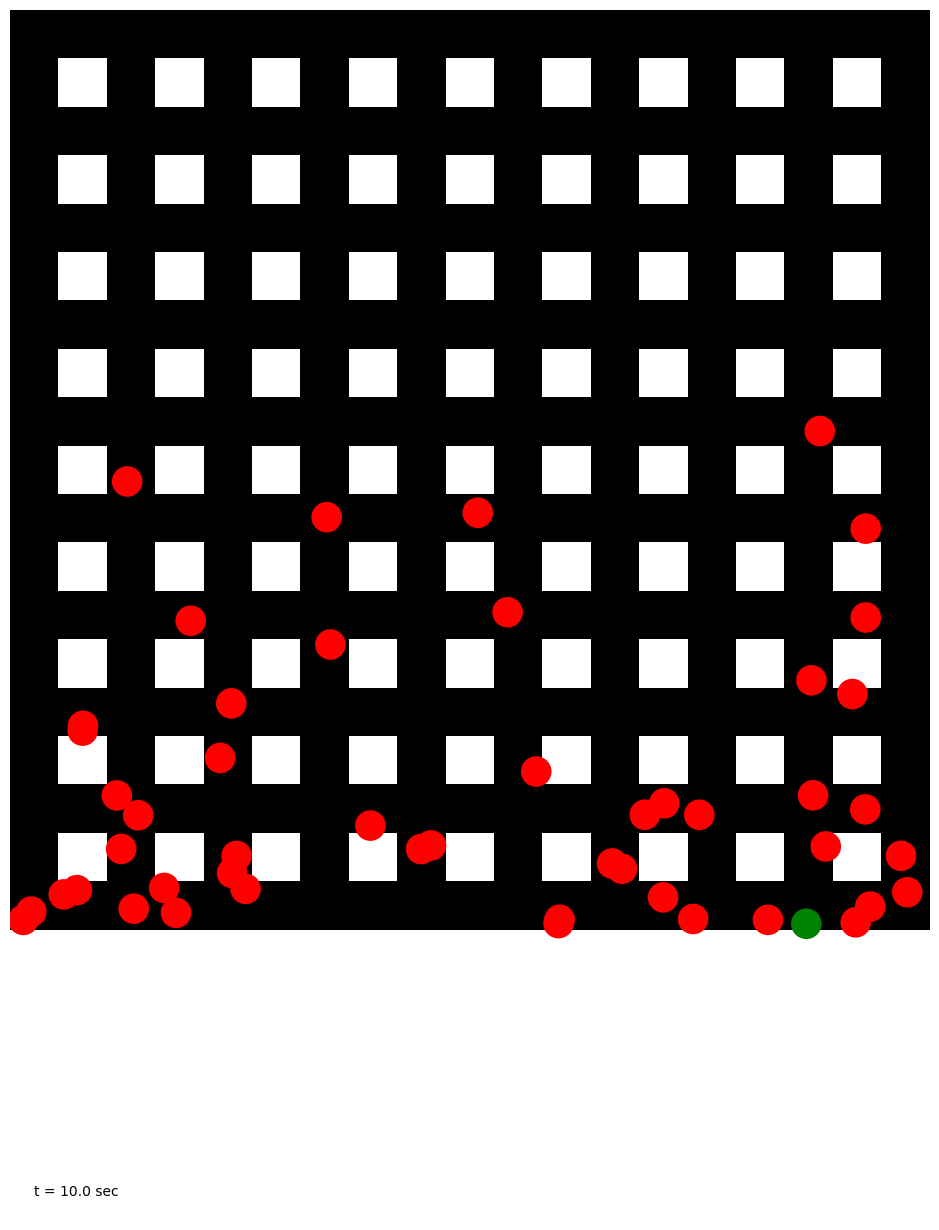

In [14]:
run = 0
time = 9

frame = int(np.argwhere(tsave[0] >= time)[0])

fig = plt.figure(figsize=(12.1, 12.1), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
vmin = 0
vmax = e.macro_params.cols - 1

ydiff = e.macro_params.rows - e.macro_params.cols

ax.set_xlim(vmin - 0.25, vmax + 0.25)
ax.set_ylim(vmin - 0.25, vmax + ydiff + 0.25)
ax.set_aspect('equal')
fig.canvas.draw()
title = ax.annotate(f"t = {tsave[run][frame]:.1f} sec", (0, 0), zorder=100)
s = ((ax.get_window_extent().width  / (vmax-vmin+0.5) * 72/(2*fig.dpi)) ** 2)
scatt_f = ax.scatter(x_f, y_f, 
                     s=s, marker='s', linewidths=0,
                     c=deg[run][frame], cmap=colormap_f, 
                     vmin=1, 
                     vmax=deg[run][ 
                                     n_save[run]-1
                                    ][deg[run][ 
                                                 n_save[run]-1
                                                ] < np.max(raw_tsave)
                                     ].max())
scatt_m = ax.scatter(x_m[run][frame], y_m[run][frame], 
                     s=s/2.5, marker='o', linewidths=0,
                     c=mol_status[run][frame], cmap=colormap_m, norm=norm_m
                     )

#scatt_h = ax.scatter(plot_coords(edge_index[143][0], edge_index[143][1])[0], plot_coords(edge_index[143][0], edge_index[143][1])[1], marker='x', c='xkcd:purple')

#fig.legend([Patch(color=colormap_m(b)) for b in [0.2, 0.8]], ["Unbound tPA", "Bound tPA"])
        
fig.show()

In [15]:
edge_index[mol_location[0,4]]

TypeError: list indices must be integers or slices, not tuple